In [1]:
from pathlib import Path

import yaml
import multiprocessing as mp

import numpy as np
import pandas as pd

import openmdao.api as om

import matplotlib.pyplot as plt
import seaborn as sns

import nsga2_weis.algo.fast_nondom_sort

In [2]:
def load_OMsql(log):
    print("loading {}".format(log))
    cr = om.CaseReader(log)
    rec_data = {}
    #driver_cases = cr.list_cases("driver")
    cases = cr.get_cases("driver")
    for case in cases:
        for key in case.outputs.keys():
            if key not in rec_data:
                rec_data[key] = []
            rec_data[key].append(case[key])

    return rec_data

In [3]:
# Multiprocssing?
post_multi = False

# sql outfile directory
run_dir = Path.cwd()
# output_dir = run_dir / "outputs" / "11_ps_check"
output_dir = run_dir / "outputs" / "04_iea22_raft_opt"
doe_logs = list(output_dir.glob("log_opt.sql*"))
N_logs = len(doe_logs)
if N_logs < 1: raise FileExistsError("No output logs to post process!")

In [4]:
# Remove the "meta" log
for idx, log in enumerate(doe_logs):
    if "meta" in log.suffix:
        doe_logs.pop(idx)
        N_logs -= 1
print(f"{N_logs} FOUND!")

95 FOUND!


In [5]:
# run multiprocessing
if post_multi:
    cores = mp.cpu_count()
    pool = mp.Pool(min(N_logs, cores))

    # load sql file
    outdata = pool.map(load_OMsql, doe_logs)
    pool.close()
    pool.join()
# no multiprocessing
else:
    outdata = [load_OMsql(log) for log in doe_logs]

collected_data = {}
for data in outdata:
    for key in data.keys():
        if key not in collected_data.keys():
            collected_data[key] = []

        for key_idx, _ in enumerate(data[key]):
            if isinstance(data[key][key_idx], int):
                collected_data[key].append(np.array(data[key][key_idx]))
            elif len(data[key][key_idx]) == 1:
                try:
                    collected_data[key].append(float(data[key][key_idx][0]))
                except:
                    collected_data[key].append(np.array(data[key][key_idx]))
            else:
                collected_data[key].append(np.array(data[key][key_idx]))

loading /Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/log_opt.sql_83
loading /Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/log_opt.sql_77
loading /Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/log_opt.sql_48
loading /Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/log_opt.sql_70
loading /Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/log_opt.sql_84
loading /Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/log_opt.sql_46
loading /Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/log_opt.sql_79
loading /Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/log_opt.sql_41
loading /Users/cfrontin/codes/WE

In [6]:
# get the problem variables
with open(output_dir / "problem_vars.yaml", 'r') as f:
    problem_vars = yaml.safe_load(f)
obj_minimize = np.ones_like([v[0] for v in problem_vars["objectives"]], dtype=bool)
for i_vset, v in enumerate([v[0] for v in problem_vars["objectives"]]):
    if "AEP" in v: obj_minimize[i_vset] = False

# convert to dataframe
df = pd.DataFrame.from_dict(collected_data)

# add pareto rankings
df["feasibility"] = True
for constr in problem_vars["constraints"]:
    df["feasibility"] &= np.array([np.all(v > float(constr[1]["lower"])) for v in df[constr[0]]])
    df["feasibility"] &= np.array([np.all(v < float(constr[1]["upper"])) for v in df[constr[0]]])

df["pareto_rank"] = -1
df.loc[df.feasibility, "pareto_rank"] = [int(v) for v in nsga2_weis.algo.fast_nondom_sort.fast_nondom_sort_ranks(
    df[[v[0] for v in problem_vars["objectives"]]][df.feasibility].to_numpy() * (2*obj_minimize - 1)
)]
df["pareto"] = df["pareto_rank"] == 0

df["pareto_rank_noconstraint"] = [int(v) for v in nsga2_weis.algo.fast_nondom_sort.fast_nondom_sort_ranks(
    df[[v[0] for v in problem_vars["objectives"]]].to_numpy() * (2*obj_minimize - 1)
)]
df["pareto_noconstraint"] = df["pareto_rank_noconstraint"] == 0

# reduce vector constraints to lower and upper
for (name, dtype) in df.dtypes.items():
    # if dtype == "object" and type(df[name][0]) == np.ndarray:
    if name in [v[0] for v in problem_vars["constraints"]]:
        df[f"{name}_lower"] = [np.min(v) for v in df[name]]
        df[f"{name}_upper"] = [np.max(v) for v in df[name]]
        df.drop(columns=name, inplace=True)

# write to file
outdata_fname = "nsga2_ps_outdata" if "11_ps" in output_dir.as_posix() else "nsga2_outdata"
outdata_fpath = output_dir / outdata_fname
df.to_csv(outdata_fpath.with_suffix(".csv"), index=False)
print("Saved {}".format(outdata_fpath.with_suffix(".csv")))

Saved /Users/cfrontin/codes/WEIS/examples/04_frequency_domain_analysis_design/outputs/04_iea22_raft_opt/nsga2_outdata.csv


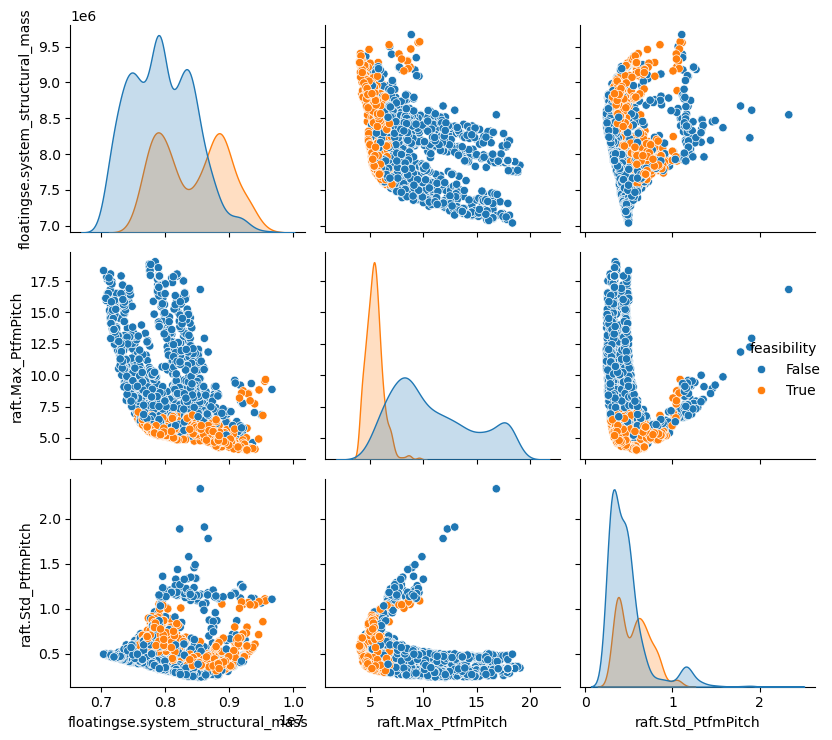

In [7]:
pg = sns.pairplot(
    df,  # df.sort_values("pareto"),
    vars=[v[0] for v in problem_vars["objectives"]],
    hue="feasibility",
)

# for ax in pg.axes.flatten():
#     ax.set_xlabel(ax.get_xlabel(), rotation=45)  # 15)
#     ax.set_ylabel(ax.get_ylabel(), rotation=45)  # 75)
pg.figure.tight_layout()

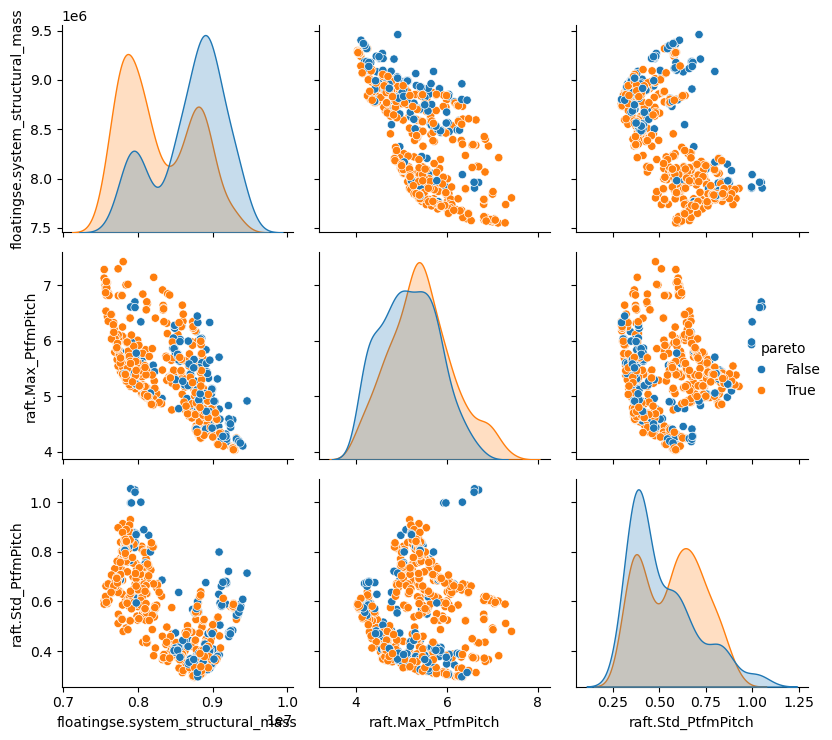

In [8]:
pg = sns.pairplot(
    # df,
    # df[df.pareto_rank == 0],
    df[(df.pareto_rank < 5) & (df.pareto_rank >= 0)],
    vars=[v[0] for v in problem_vars["objectives"]],
    hue="pareto",
    # hue="feasibility",
    diag_kws={"common_norm": False},
)
pg.figure.tight_layout()

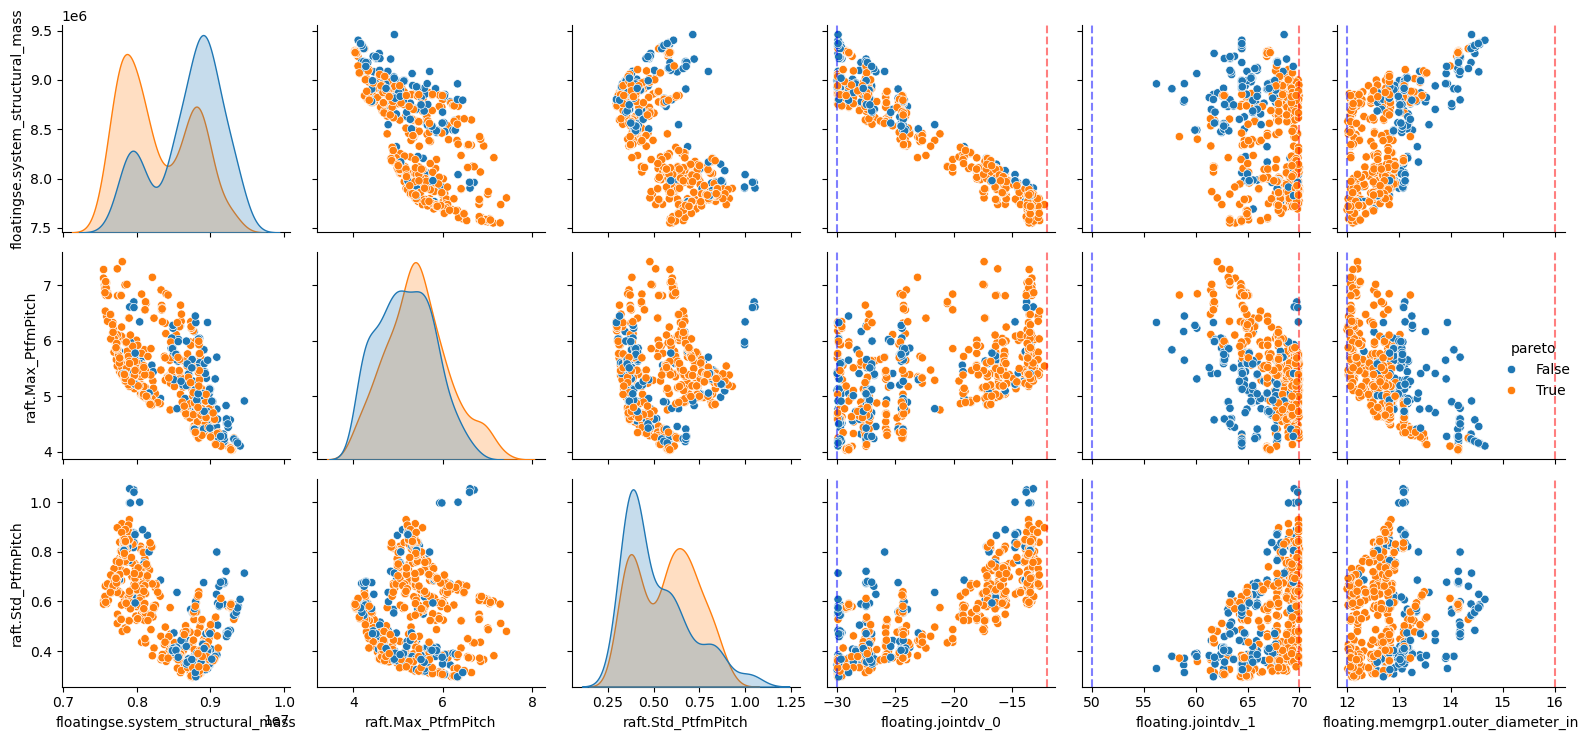

In [9]:
pg = sns.pairplot(
    # df,
    # df[df.pareto_rank == 0],
    df[(df.pareto_rank < 5) & (df.pareto_rank >= 0)],
    y_vars=[
        v[0] for v in problem_vars["objectives"]
    # ] + [
    #     v[0] for v in problem_vars["design_vars"]
    ],
    x_vars=[
        v[0] for v in problem_vars["objectives"]
    ] + [
        v[0] for v in problem_vars["design_vars"]
    ],
    # hue="feasibility",
    hue="pareto",
    # hue="pareto_rank",
    diag_kws={"common_norm": False},
)

dvv = dict(problem_vars["design_vars"])
for ixv, xv in enumerate(pg.x_vars):
    for iyv, yv in enumerate(pg.y_vars):
        if xv in dvv:
            pg.axes[iyv, ixv].axvline(dvv[xv]["lower"], linestyle="--", color="blue", alpha=0.5)
            pg.axes[iyv, ixv].axvline(dvv[xv]["upper"], linestyle="--", color="red", alpha=0.5)
        if (yv in dvv) and (ixv != iyv):
            pg.axes[iyv, ixv].axhline(dvv[yv]["lower"], linestyle="--", color="blue", alpha=0.5)
            pg.axes[iyv, ixv].axhline(dvv[yv]["upper"], linestyle="--", color="red", alpha=0.5)
pg.figure.tight_layout()

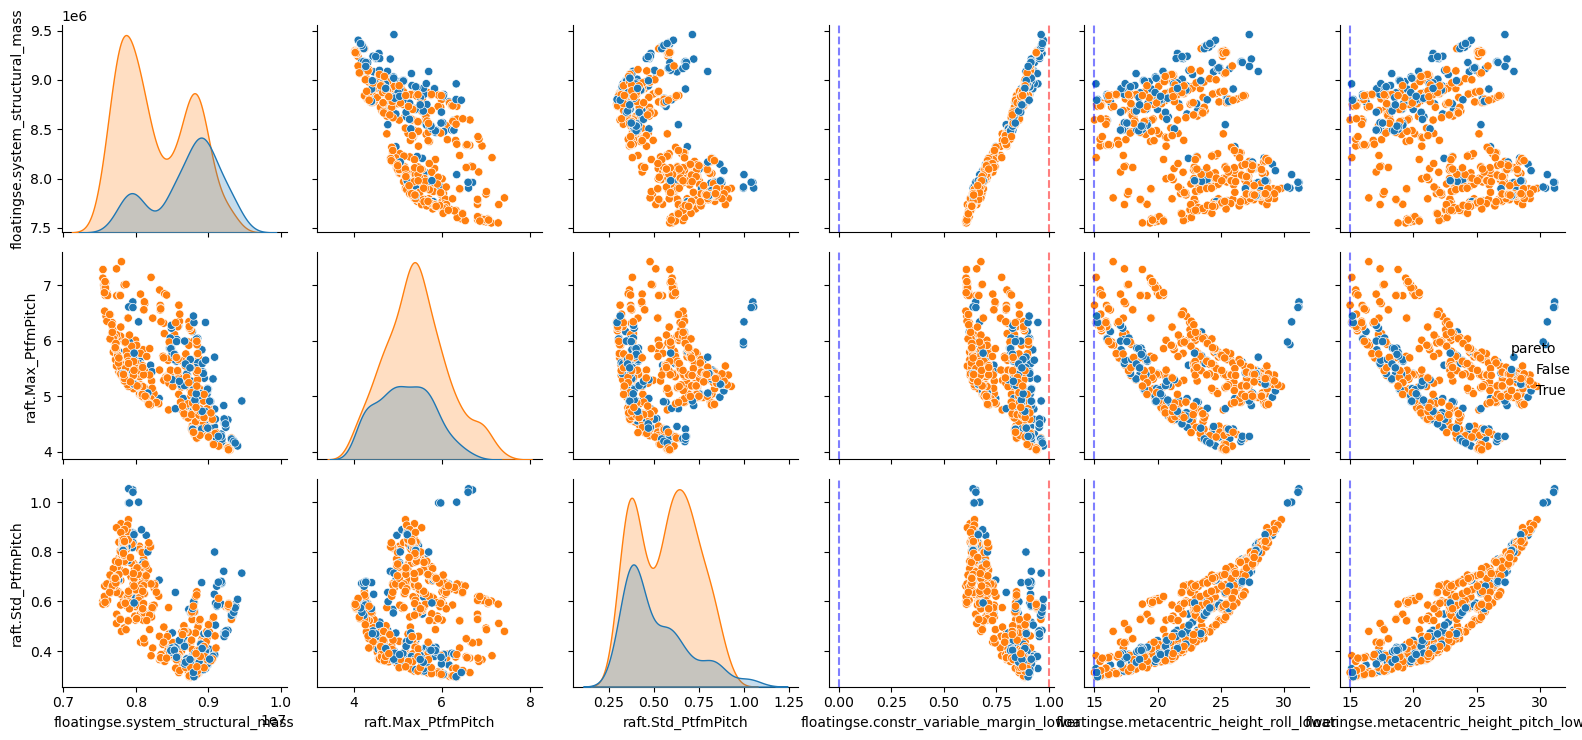

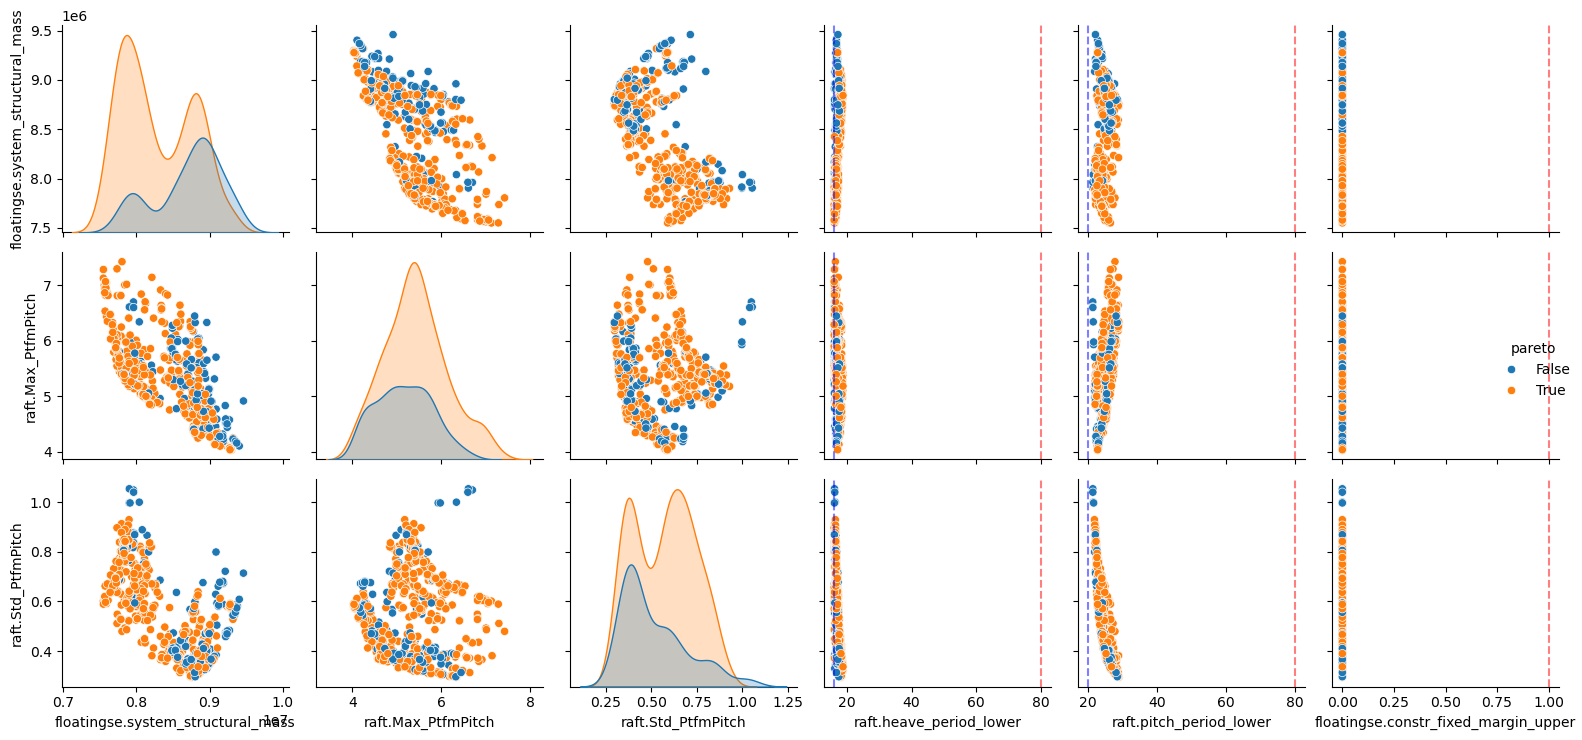

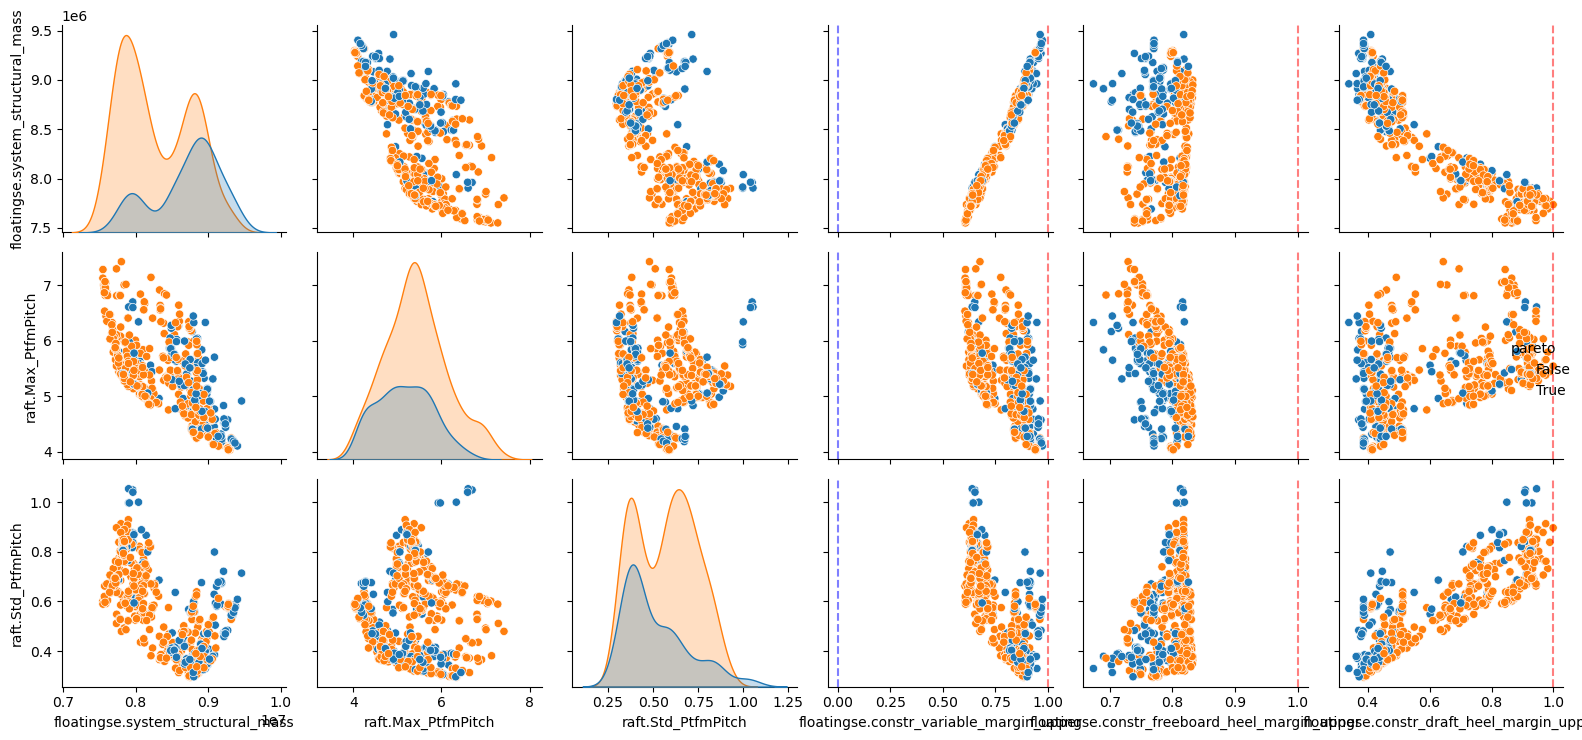

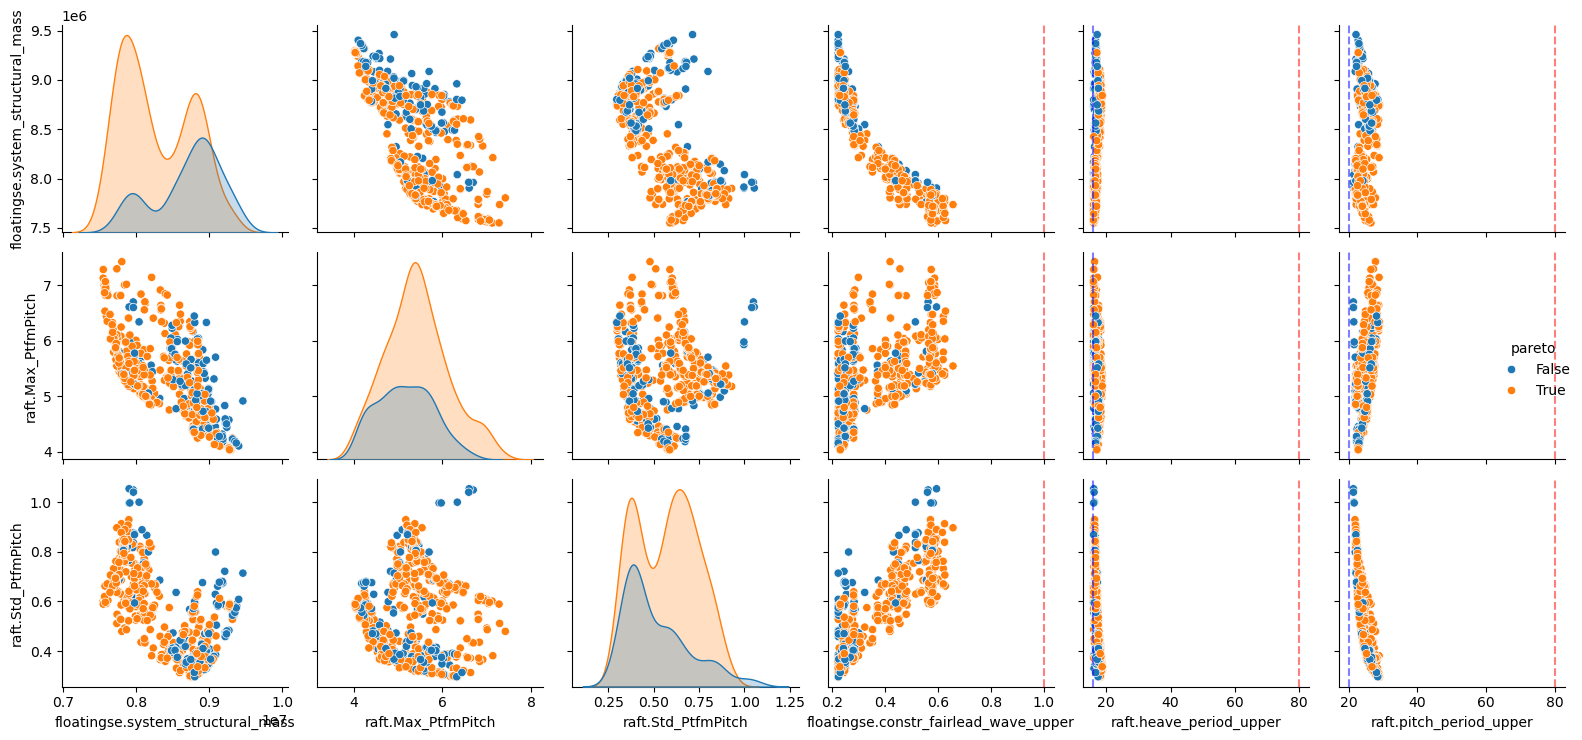

In [10]:
vset = [
    f"{v[0]}_lower" for v in problem_vars["constraints"] if (float(v[1]["lower"]) > -1e30)
] + [
    f"{v[0]}_upper" for v in problem_vars["constraints"] if (float(v[1]["upper"]) < 1e30)
]

# cycle through vset N-at-a-time
N_vset = 3
for i_vset in range(0, len(vset), N_vset):

    pg = sns.pairplot(
        # df,
        # df[df.pareto_rank == 0],
        df[(df.pareto_rank < 5) & (df.pareto_rank >= 0)],
        y_vars=[
            v[0] for v in problem_vars["objectives"]
        ],
        x_vars=[
            v[0] for v in problem_vars["objectives"]
        ] + vset[i_vset:i_vset+N_vset],
        # ] + [
        #     f"{v[0]}_lower" for v in problem_vars["constraints"] if (float(v[1]["lower"]) > -1e30)
        # ] + [
        #     f"{v[0]}_upper" for v in problem_vars["constraints"] if (float(v[1]["upper"]) < 1e30)
        # ],
        hue="pareto",
        # hue="pareto_rank",
    )

    cvv = dict(problem_vars["constraints"])
    for ixv, xv in enumerate(pg.x_vars):
        xv_tidy = xv.removesuffix("_lower") if xv.endswith("_lower") else xv.removesuffix("_upper")
        for iyv, yv in enumerate(pg.y_vars):
            yv_tidy = yv.removesuffix("_lower") if yv.endswith("_lower") else yv.removesuffix("_upper")
            if xv_tidy in cvv:
                if float(cvv[xv_tidy]["lower"]) > -1e30: pg.axes[iyv, ixv].axvline(cvv[xv_tidy]["lower"], linestyle="--", color="blue", alpha=0.5)
                if float(cvv[xv_tidy]["upper"]) < +1e30: pg.axes[iyv, ixv].axvline(cvv[xv_tidy]["upper"], linestyle="--", color="red", alpha=0.5)
            if (yv_tidy in cvv) and (ixv != iyv):
                if float(cvv[yv_tidy]["lower"]) > -1e30: pg.axes[iyv, ixv].axhline(cvv[yv_tidy]["lower"], linestyle="--", color="blue", alpha=0.5)
                if float(cvv[yv_tidy]["upper"]) < +1e30: pg.axes[iyv, ixv].axhline(cvv[yv_tidy]["upper"], linestyle="--", color="red", alpha=0.5)
    pg.figure.tight_layout()